In [129]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Masking


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Dropout, Bidirectional

In [161]:
df = pd.read_csv('../../wildfire_prediction/data/merged_file.csv', index_col=0, nrows=5000)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 49 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Date_x                                                    5000 non-null   object 
 1   Region                                                    5000 non-null   object 
 2   count()[unit: km^2]                                       5000 non-null   float64
 3   max() Precipitation                                       5000 non-null   float64
 4   max() RelativeHumidity                                    4993 non-null   float64
 5   max() SoilWaterContent                                    5000 non-null   float64
 6   max() SolarRadiation                                      5000 non-null   float64
 7   max() Temperature                                         5000 non-null   float64
 8   max() WindSpeed   

In [163]:
df.drop(columns=['max() Precipitation', 
                 'max() RelativeHumidity',
                 'max() SoilWaterContent',
                 'max() SolarRadiation',
                 'max() WindSpeed',
                 'mean() SoilWaterContent',
                 'min() Precipitation', 
                 'min() RelativeHumidity',
                 'min() SoilWaterContent',
                 'min() SolarRadiation',
                 'min() WindSpeed',
                 'variance() Precipitation', 
                 'variance() RelativeHumidity',
                 'variance() SoilWaterContent',
                 'variance() SolarRadiation',
                 'variance() WindSpeed',
                 'variance() Temperature',
                 'Mean_estimated_fire_brightness',
                 'Mean_estimated_fire_radiative_power',
                 'Year',
                 'Month',
                 'Day'
                 ], inplace=True)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Date_x                                                    5000 non-null   object 
 1   Region                                                    5000 non-null   object 
 2   count()[unit: km^2]                                       5000 non-null   float64
 3   max() Temperature                                         5000 non-null   float64
 4   mean() Precipitation                                      5000 non-null   float64
 5   mean() RelativeHumidity                                   4993 non-null   float64
 6   mean() SolarRadiation                                     5000 non-null   float64
 7   mean() Temperature                                        5000 non-null   float64
 8   mean() WindSpeed  

In [165]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# corr = np.abs(df.corr())
# plt.figure(figsize=(18, 16))
# sns.heatmap(corr)
# plt.show()

In [166]:
#Replacing na by 0
df.Estimated_fire_area.fillna(0, inplace=True)
# df.Mean_estimated_fire_brightness.fillna(0, inplace=True)
# df.Mean_estimated_fire_radiative_power.fillna(0, inplace=True)

#Solar Radiation to UV
df['mean() SolarRadiation'] = df['mean() SolarRadiation']*0.1
#Defining features and target
X = df.drop(columns=['Estimated_fire_area', 'Date_x'])
y = df.Estimated_fire_area


#Region Encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[['Region']])
encoder.categories_
for i, col in enumerate(encoder.categories_[0]):
    X[col] = pd.DataFrame(encoded)[i]
X.drop(columns='Region', inplace=True)

#Imputing null values
numerical_features = X.dtypes[(df.dtypes == 'float64') | (X.dtypes == 'int64')].index
imputer = KNNImputer()
values = imputer.fit_transform(X[X.dtypes[(df.dtypes == 'float64') | (X.dtypes == 'int64')].index])
X[X.dtypes[(df.dtypes == 'float64') | (X.dtypes == 'int64')].index] = values

#Train Test Split
len_ = int(0.8*df.shape[0])
X_train = X[:len_]
X_test = X[len_:]
y_train = y[:len_]
y_test = y[len_:]

In [167]:
X_train

,count()[unit: km^2],max() Temperature,mean() Precipitation,mean() RelativeHumidity,mean() SolarRadiation,mean() Temperature,mean() WindSpeed,min() Temperature,Vegetation_index_mean,Vegetation_index_variance,...,"Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea,NSW,NT,QL,SA,TA,VI,WA
0,8.002343e+05,35.878704,0.044274,36.355567,2.674939,27.341182,3.323550,14.485785,0.349202,0.041968,...,3.7,10.3,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.357561e+06,38.136787,9.884958,61.494675,1.978179,29.881492,5.296892,24.179960,0.300478,0.023293,...,13.6,9.3,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.730605e+06,37.047943,1.453053,47.959364,2.705698,28.842866,3.483753,20.951620,0.357081,0.033013,...,12.0,11.0,0.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9.913151e+05,38.326847,0.059078,30.057683,2.714264,30.793675,4.657538,14.095855,0.179208,0.005836,...,1.4,5.3,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6.778526e+04,16.228510,3.099497,65.086764,2.675571,11.788805,5.408138,6.686816,0.638585,0.028846,...,1.5,7.2,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2.294532e+05,12.696275,1.107442,87.732830,0.862714,8.785697,1.729909,4.772664,0.604092,0.036011,...,2.7,5.2,0.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3996,2.528546e+06,23.693451,0.050477,52.885717,1.410678,15.126799,2.919952,7.039271,0.285216,0.013168,...,4.8,8.7,0.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3997,8.002343e+05,15.510233,0.294394,82.559445,1.049940,9.685207,1.582037,3.512131,0.444227,0.031492,...,3.7,10.3,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,1.357561e+06,24.177727,0.000043,42.223288,1.881599,16.066594,3.098414,11.560211,0.300528,0.012942,...,13.6,9.3,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [168]:
df['mean() SolarRadiation'].describe()

count    5000.000000
mean        1.920766
std         0.689015
min         0.177741
25%         1.410667
50%         1.943924
75%         2.487820
max         3.381436
Name: mean() SolarRadiation, dtype: float64

In [169]:
print(X_train.shape, X_test.shape, X_train.shape[0]/len(df))
print(y_train.shape, y_test.shape, y_train.shape[0]/len(df))

(4000, 31) (1000, 31) 0.8
(4000,) (1000,) 0.8


In [170]:
X_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.to_numpy().reshape((y_test.shape[0],1))

In [171]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X_train)

<tf.Tensor: shape=(4000, 31, 1), dtype=float32, numpy=
array([[[ 3.1687682 ],
        [-0.14704135],
        [-0.14718986],
        ...,
        [-0.14719003],
        [-0.14719003],
        [-0.14719003]],

       [[ 5.478181  ],
        [-0.147032  ],
        [-0.14714906],
        ...,
        [-0.14719003],
        [-0.14719003],
        [-0.14719003]],

       [[ 7.023977  ],
        [-0.14703651],
        [-0.147184  ],
        ...,
        [-0.14719003],
        [-0.14719003],
        [-0.14719003]],

       ...,

       [[ 3.1687682 ],
        [-0.14712575],
        [-0.14718881],
        ...,
        [-0.14719003],
        [-0.14719003],
        [-0.14719003]],

       [[ 5.478181  ],
        [-0.14708985],
        [-0.14719003],
        ...,
        [-0.14719003],
        [-0.14719003],
        [-0.14719003]],

       [[ 7.023977  ],
        [-0.14708947],
        [-0.14718997],
        ...,
        [-0.14719003],
        [-0.14719003],
        [-0.14719003]]], dtype=float32)

In [172]:
def init_model():
    
#     model = Sequential()
#     model.add(layers.LSTM(20, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1],1)))
#     model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
#     model.add(layers.Dense(5, activation='relu'))
#     model.add(layers.Dense(1, activation='linear'))
    

    
#     opt = RMSprop(learning_rate=0.005)
#     normalizer = Normalization()
#     normalizer.adapt(X_train)

    model = Sequential()
#     model.add(Normalization().adapt(X_train))
    model.add(layers.LSTM(200, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.1))
    model.add(layers.LSTM(150, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(100, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(layers.SimpleRNN(30, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='Adam', 
                  metrics=['mae'])
#     model.compile(loss='mse', 
#                   optimizer=RMSprop(learning_rate=0.0003), 
#                   metrics=['mae'])
    
    return model

In [173]:
model = init_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 31, 200)           161600    
_________________________________________________________________
dropout_28 (Dropout)         (None, 31, 200)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 31, 150)           210600    
_________________________________________________________________
dropout_29 (Dropout)         (None, 31, 150)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 31, 100)           100400    
_________________________________________________________________
dropout_30 (Dropout)         (None, 31, 100)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 30)              

In [174]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=500, 
            batch_size=64,
            callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


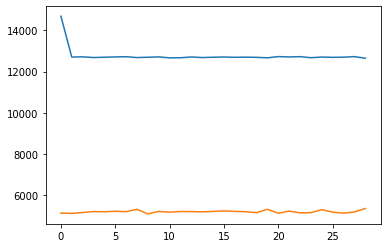

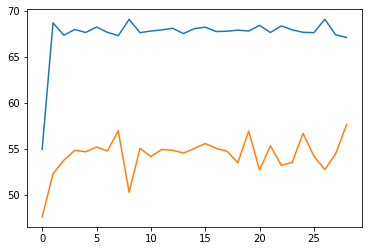

In [175]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [176]:
res = model.evaluate(X_test, y_test, verbose=0)
print(res)
print(f'mae on the test set : {res[1]:.0f}')

[206439.953125, 234.01046752929688]
mae on the test set : 234


In [177]:
y_pred = model.predict(X_test)

In [178]:
np.sqrt((y_test-y_pred)**2).mean()

234.01046000250733

In [189]:
import datetime
month = datetime.datetime.today().month

In [179]:
data = pd.read_csv('../../wildfire_prediction/data/wfz_data.csv',\
         index_col=0, nrows=5000)

In [194]:
filtered_data = data[(data.index == month) & (data.Region == 'TA')]


In [195]:
filtered_data.columns

Index(['Region', 'count()[unit: km^2]', 'Vegetation_index_mean', 'Shrubs',
       'Herbaceous vegetation',
       'Cultivated and managed vegetation/agriculture (cropland)',
       'Urban / built up', 'Bare / sparse vegetation',
       'Permanent water bodies', 'Herbaceous wetland', 'Open sea', 'Forest'],
      dtype='object')

In [205]:
values = {f'{col}': filtered_data['Region'].values[0] for col in filtered_data.columns}

In [207]:
values

{'Region': 'TA',
 'count()[unit: km^2]': 'TA',
 'Vegetation_index_mean': 'TA',
 'Shrubs': 'TA',
 'Herbaceous vegetation': 'TA',
 'Cultivated and managed vegetation/agriculture (cropland)': 'TA',
 'Urban / built up': 'TA',
 'Bare / sparse vegetation': 'TA',
 'Permanent water bodies': 'TA',
 'Herbaceous wetland': 'TA',
 'Open sea': 'TA',
 'Forest': 'TA'}